In [2]:
# Import modules
import pickle
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

/Users/TX/anaconda/envs/carnd-term1/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Camera Calibration

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y


objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)
# cv2.destroyAllWindows()

In [30]:
# Undistort the image
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

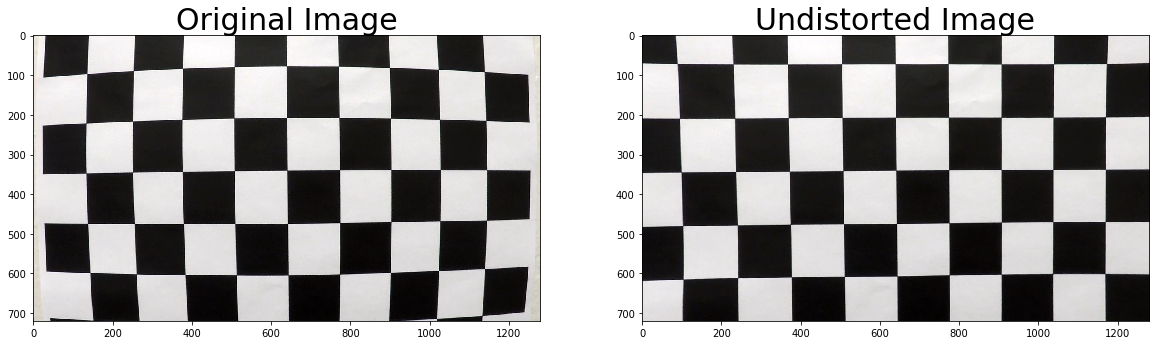

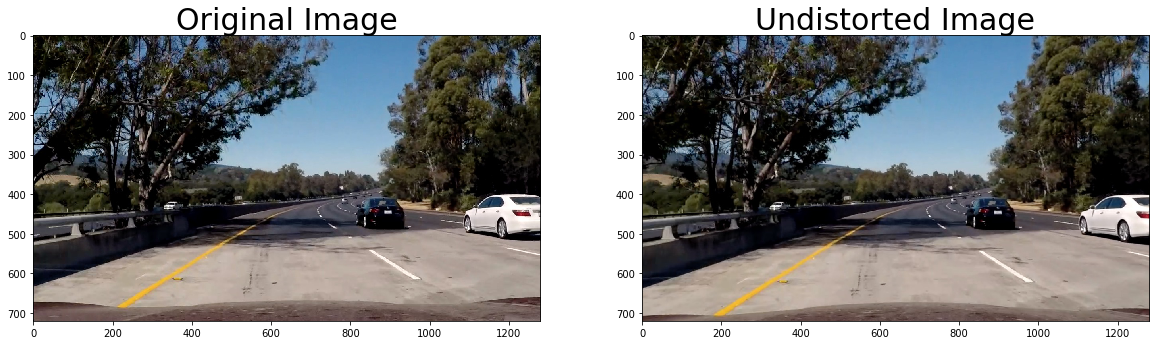

In [31]:
# Test undistortion on an image
img = mpimg.imread('camera_cal/calibration1.jpg')
dst = undistort(img)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

test5 = mpimg.imread('test_images/test5.jpg')
test5_undist = undistort(test5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test1_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

## Different Thresholding Functions

In [5]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary

In [6]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary

In [7]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary

In [8]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

## Interactive Thresholding Adjustment

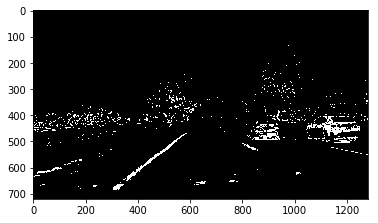

In [83]:
# Combining thresholds
image = mpimg.imread('test_images/test4.jpg')
def update(ksize, min_gradx, max_gradx, min_grady, max_grady, min_mag, max_mag, min_dir, max_dir, min_s, max_s):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(min_gradx,max_gradx))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(min_grady,max_grady))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(min_mag,max_mag))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(min_dir,max_dir))
    s_binary = hls_select(image, thresh=(min_s,max_s))
    
    combined = np.zeros_like(dir_binary)
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    plt.imshow(combined, cmap='gray')
# # Run the function
# grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
# # Run the function
# mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# # Run the function
# dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))


interact(update, ksize=(1,31,2),
         min_gradx=(0,255), max_gradx=(0,255),
         min_grady=(0,255), max_grady=(0,255),
         min_mag = (0,255), max_mag = (0,255),
         min_dir=(0,np.pi/2), max_dir=(0,np.pi/2),
         min_s   = (0,255),    max_s = (0,255));

## Thresholding Pipeline & Testing

In [84]:
def thresh_pipeline(image, ksize=15, min_gradx=76, max_gradx=162, min_grady=84, max_grady=155, min_mag=87, max_mag=227, min_dir=0.9, max_dir=1.10, min_s=160, max_s=255):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(min_gradx,max_gradx))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(min_grady,max_grady))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(min_mag,max_mag))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(min_dir,max_dir))
    s_binary = hls_select(image, thresh=(min_s,max_s))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    return combined

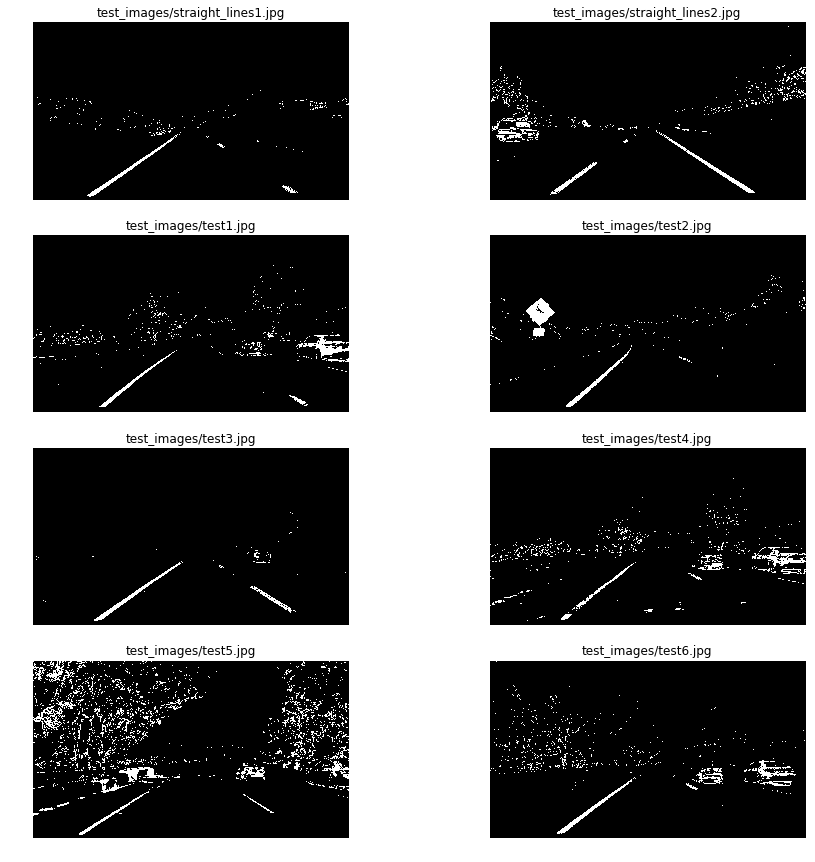

In [85]:
images = glob.glob('test_images/*.jpg')
plt.figure(figsize=(15,15))
for idx, fname in enumerate(images):
    plt.subplot(4,2,idx+1)
    img = mpimg.imread(fname)
    img_undist = undistort(img)
    img_binary = thresh_pipeline(img_undist)
    plt.axis('off')
    plt.title(fname)
    plt.imshow(img_binary, cmap='gray')

## Perspective Transform (Bird-eye View)

In [34]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
# dist_pickle = pickle.load( open("camera_cal/wide_dist_pickle.p", "rb" ) )
# mtx = dist_pickle["mtx"]
# dist = dist_pickle["dist"]

# Perspective transform on unistorted image
def perspective_transform(img):
    img_size = img.shape[0:2]
    height = img_size[0] #720
    width = img_size[1] #1280
    top_left_x = width * 0.45 #576
    top_right_x = width * 0.55 #704
    top_y = height * 0.63 #453
    dst_top_left_x = width * 0.25 # 320
    dst_top_right_x = width * 0.75 # 960
    
    src = np.float32([[top_left_x, top_y], [top_right_x, top_y],
                       [width, height], [0, height]])
    dst = np.float32([[dst_top_left_x, 0], [dst_top_right_x, 0], 
                      [dst_top_right_x, height], [dst_top_left_x, height]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
    return warped, Minv

## Plot Original, Top-down and Histogram

In [119]:
def plot_ori_bird(image):
    img_undist = undistort(image)
    img_binary = thresh_pipeline(img_undist)
    top_down, Minv = perspective_transform(img_binary)
    histogram = np.sum(top_down[top_down.shape[0]/2:,:], axis=0);
    
    
    plt.figure(figsize=(13,2))
    plt.subplot(1,3,1)
    plt.imshow(image,cmap='gray')
    plt.title('original')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(top_down,cmap='gray')
    plt.title('Bird-eye view')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.plot(histogram)
    plt.title('Histogram')

/Users/TX/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


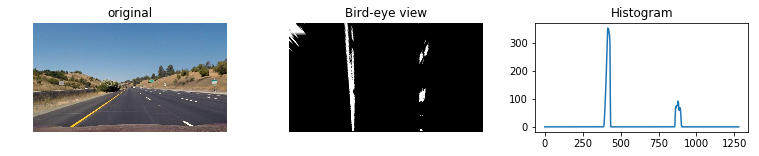

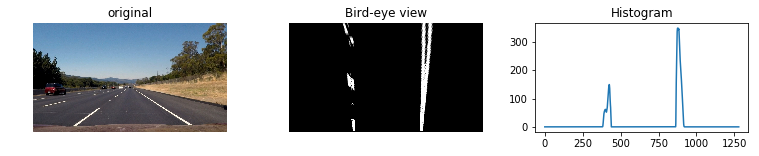

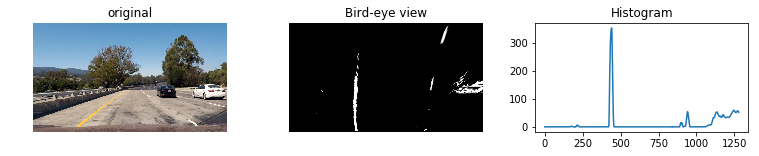

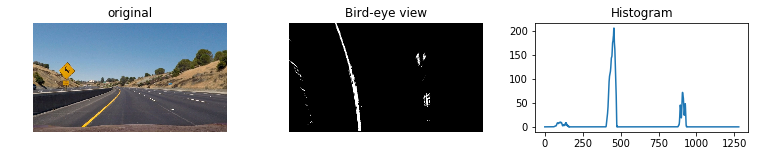

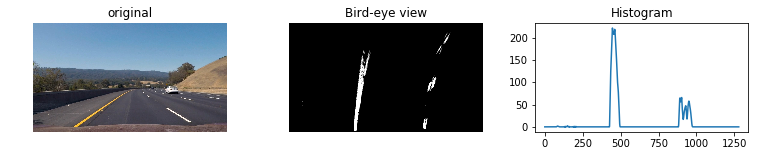

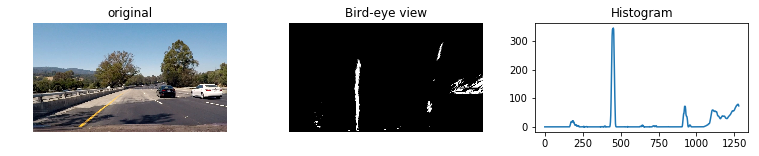

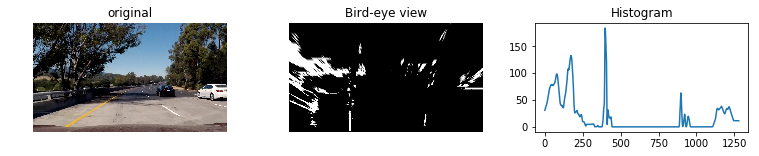

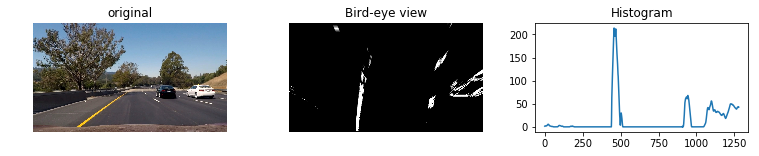

In [120]:
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    plot_ori_bird(img)

## Fit Lines